# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

**Answer: **

In the terminology of machine learning, classification [Statistical classification](https://en.wikipedia.org/wiki/Statistical_classification) is considered an instance of supervised learning, i.e. learning where a training set of correctly identified observations is available. The corresponding unsupervised procedure is known as clustering, and involves grouping data into categories based on some measure of inherent similarity or distance. Based on the definition of classification we can clearly see that this supervised learning problem belongs to classification as our main task is to arrange the students in basically two categories: the students who need early intervention from the ones who are on the right track to graduate. The final goal is to identify the students who need early help so that they can successfuly graduate.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [4]:
# Import libraries
import numpy as np
import pandas as pd

In [18]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!

Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [24]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = len(student_data.index)
n_features = len(student_data.columns)-1
n_passed = len(student_data[(student_data["passed"]=="yes")])
n_failed = len(student_data[(student_data["passed"]=="no")])
grad_rate = float(n_passed) / float(n_passed+n_failed) * 100.0
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%

Pro Tip:

When dealing with the new data set it is good practice to assess its specific characteristics and implement the cross validation technique tailored on those very characteristics, in our case there are two main elements:

    1. Our dataset is small.
    2. Our dataset is slightly unbalanced. (There are more passing students than on passing students)

We could take advantage of K-fold cross validation to exploit small data sets. Even though in this case it might not be necessary, should we have to deal with heavily unbalance datasets, we could address the unbalanced nature of our data set using Stratified [K-Fold](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedKFold.html) and [Stratified Shuffle Split Cross validation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html), as stratification is preserving the preserving the percentage of samples for each class.

## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem,
as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`passed`) is the target or label we are trying to predict.

In [34]:
# Extract feature (X) and target (y) columns

# all columns but last are features:
feature_cols = list(student_data.columns[:-1])
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

# feature values for all students:
X_all = student_data[feature_cols]
# corresponding targets/labels: 
y_all = student_data[target_col].replace(['yes', 'no'], [1, 0])
print "\nFeature values:-"

# print the first 5 rows:
print X_all.head()  # print the first 5 rows

Feature column(s): ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures',
'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic',
'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed
Feature values: 
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher
1     GP   F   17       U     GT3       T     1     1  at_home     other
2     GP   F   15       U     LE3       T     1     1  at_home     other
3     GP   F   15       U     GT3       T     4     2   health  services
4     GP   F   16       U     GT3       T     3     3    other     other

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3
1   ...       yes      yes     

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [44]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)
            # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data) # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U',
'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home',
'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other',
'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime',
'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [59]:
from sklearn.cross_validation import StratifiedShuffleSplit

def strat_shuffle_split(features_data, target_data):
    #Shuffling data to avoid any ordering bias in the dataset

    num_size = 95
    sss = StratifiedShuffleSplit(target_data, test_size=num_size, n_iter = 50,random_state=42)

    for train_index, test_index in sss:
       X_train, X_test = features_data.iloc[train_index], features_data.iloc[test_index]
       y_train, y_test = target_data[train_index], target_data[test_index]

    return X_train, y_train, X_test, y_test

In [184]:
# First, decide how many training vs test samples you want
#num_all = student_data.shape[0]  # same as len(student_data)
#num_train = 300  # about 75% of the data
#num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the
#       dataset

features_data = X_all
target_data = y_all

#Stratified shuffle split
X_train, y_train, X_test, y_test = strat_shuffle_split(features_data, target_data)
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples

## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [78]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

# TODO: Choose a model, import it and instantiate an object
from sklearn.svm import SVC #for Model 1
SVM_clf = SVC()

# Fit model to training data
train_classifier(SVM_clf, X_train, y_train)  # note: using entire training set here
#print SVM_clf  # you can inspect the learned model by printing it

Training SVC...
Done!
Training time (secs): 0.057

In [101]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label=1)

train_f1_score = predict_labels(SVM_clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)

Predicting labels using SVC...
Done!
Prediction time (secs): 0.012
F1 score for training set: 0.851694915254

In [115]:
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(SVM_clf, X_test, y_test))

Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.829931972789

In [78]:
# TODO: Train and predict using two other models

#Model #2
# TODO: Choose a model, import it and instantiate an object
from sklearn.ensemble import RandomForestClassifier #for Model #2
RF_clf = RandomForestClassifier(n_estimators=15)

# Fit model to training data
train_classifier(RF_clf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

train_f1_score = predict_labels(RF_clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(SVM_clf, X_test, y_test))

print "--------------------------------------"

#Model #3
# TODO: Choose a model, import it and instantiate an object
from sklearn.neighbors import KNeighborsClassifier #for Model 3
from sklearn.ensemble import BaggingClassifier
bagging_clf = BaggingClassifier(KNeighborsClassifier(n_neighbors=3),
max_samples=0.5, max_features=0.5)

# Fit model to training data
train_classifier(bagging_clf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

train_f1_score = predict_labels(bagging_clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(SVM_clf, X_test, y_test))

Training RandomForestClassifier...
Done!
Training time (secs): 0.134
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.004
F1 score for training set: 1.0
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.829931972789
--------------------------------------
Training BaggingClassifier...
Done!
Training time (secs): 0.052
Predicting labels using BaggingClassifier...
Done!
Prediction time (secs): 0.032
F1 score for training set: 0.864142538976
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.829931972789

**Model 1: **

- What are the general applications of this model? What are its strengths and weaknesses?

    The general applications of SVM classifier (Testing Model) are that it can be applied to classification, anomalies detection, and regression problems. [SVM classifier](https://www.safaribooksonline.com/library/view/scala-for-machine/9781783558742/ch08s03.html)

  * The strengths of SVM classifier (Testing Model) are that it is accurate and less overfitting, robust to noise. [SVM strengths](http://condor.depaul.edu/ntomuro/courses/578/notes/SVM-overview.pdf)

 * The weaknesses of SVM classifier (Testing Model) are that it is computationally expensive, thus runs slow SVM. Also it is a binary classifier. To do a multi-class classification, pair-wise classifications can be used (one class against all others, for all classes). [SVM weaknesses](http://condor.depaul.edu/ntomuro/courses/578/notes/SVM-overview.pdf)


- Given what you know about the data so far, why did you choose this model to apply?

    I chose the SVM classifier (Testing Model) to apply because I followed the logic of the Machine Learning scikit-learn diagram [ML scikit-learn diagram](http://scikit-learn.org/stable/tutorial/machine_learning_map/). Given that I count with less than 100k samples, that I am working with non text data, and that in the KNearest neighbors K-nearest neighbours the model can not be interpreted (there is no description of the learned concepts), I chose to work with the SVM nonlinear classifier. 


- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Model SVM classifier
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

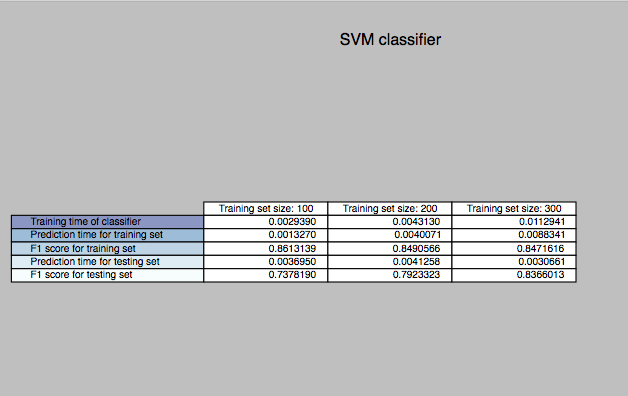

In [312]:
#Refer to Line 312 from student_intervention.py or to the following code
#The outcome from the following code are 3 tables.
#Below I am only showing the table from the Model #1 (SVM classifier)

import numpy as np
import pandas as pd
import time
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.svm import SVC #for Model 1: SVC
from sklearn.ensemble import RandomForestClassifier #for Model 2: Randomized Forest
from sklearn.neighbors import KNeighborsClassifier  #for Model 3: Bagging Classifier with KNN
from sklearn.ensemble import BaggingClassifier #for Model 3: Bagging Classifier with KNN

def load_data():
    #Load the student dataset.
    student = pd.read_csv("student-data.csv")
    #print "Student data read successfully!"
    return student

def explore_student_data(student_data):
    #refer to Line 73 from student_intervention.py
    feature_cols = list(student_data.columns[:-1])
    target_col = student_data.columns[-1]
    X = student_data[feature_cols]  # feature values for all students
    # below we replace the corresponding targets/labels
    y = student_data[target_col].replace(['yes', 'no'], [1, 0])
    #print "Feature column(s): {}".format(feature_cols)
    #print "Target column: {}".format(target_col)
    #print "Feature values: "
    #print X.head()  # print the first 5 rows
    return X, y

def preprocess_features(student_data):
    #Replace missing data and invalid data
    #next is the output dataframe, initially empty
    out_Student_data = pd.DataFrame(index=student_data.index)
    # Check each column
    for col, col_data in student_data.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
            # Note: This should change the data type for yes/no columns to int
            # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)
            #col_data e.g. 'school' => 'school_GP', 'school_MS'
        # next we collect column(s) in output dataframe
        out_Student_data = out_Student_data.join(col_data)
    return out_Student_data

def strat_shuffle_split(features_data, target_data):
    #Shuffle data to avoid any ordering bias in the dataset

    num_size = 95
    sss= StratifiedShuffleSplit(target_data, test_size=num_size, n_iter=50, random_state=42)

    for train_index, test_index in sss:
       X_train, X_test = features_data.iloc[train_index], features_data.iloc[test_index]
       y_train, y_test = target_data[train_index], target_data[test_index]

    return X_train, y_train, X_test, y_test

def split_data(X, y, num_train):
    #Split data according to num_train
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=num_train)
    return X_train, y_train, X_test, y_test

def train_classifier(clf, X_train, y_train, grid=False):
    start = time.time()
    clf.fit(X_train, y_train)
    if grid:
        clf = clf.best_estimator_
    end = time.time()
    training_time = end - start
    return training_time 

# Predict on training set and compute F1 score
def predict_labels(clf, features, target):
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    prediction_time = end - start
    return (prediction_time, f1_score(target.values, y_pred, pos_label=1))

################### Creating Table ###################
#Source: http://matplotlib.org/examples/pylab_examples/table_demo.html
######################################################

import matplotlib.pyplot as plt
#import numpy as np #already have it

def create_table(model, model_name, train_num, X, y): 
    all_data = [] #right location
    columns = ['Training set size: %d' % x for x in train_num]
    rows = [ 
      "Training time of classifier     ", 
      "Prediction time for training set", 
      "F1 score for training set       ", 
      "Prediction time for testing set ", 
      "F1 score for testing set        "]
    for num in train_num:
        data = []
        # Split data
        X_train, y_train, X_test, y_test = split_data(X, y, num)
        #"{0:.2f}".format(round(a,2))
        data = [ 
                "{0:.7f}".format(round(train_classifier(model, X_train, y_train),7)), 
                "{0:.7f}".format(round(predict_labels(model, X_train, y_train)[0],7)), 
                "{0:.7f}".format(round(predict_labels(model, X_train, y_train)[1],7)), 
                "{0:.7f}".format(round(predict_labels(model, X_test, y_test)[0],7)), 
                "{0:.7f}".format(round(predict_labels(model, X_test, y_test)[1],7)) 
                ] 
        all_data.append(data) 
    #accomodating data
    all_ordered_data = []
    num_cols = len(all_data)
    num_rows = len(all_data[0])
    #loop
    r_count = 0
    while r_count < num_rows: #loops from 0 up to 4
        ordered_data = []
        c_count = 0
        while c_count < num_cols: #visits all_data[0], all_data[1], all_data[2]
            ordered_data.append(all_data[c_count][r_count])
            c_count += 1
        all_ordered_data.append(ordered_data)
        r_count += 1

   #Get some pastel shades for the colors
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
    # Reverse colors and text labels to display the last value at the top.
    colors = colors[::-1]

   #Add a table at the bottom of the axes
    the_table = plt.table(cellText=all_ordered_data,
                          rowLabels=rows,    ##row labels must be length 3 
                          rowColours=colors,
                          colLabels=columns,
                          loc='center')
    #show table
    plt.title('{}'.format(model_name))
    plt.axis('off')
    plt.savefig("table_{}.png".format(model_name)) #k components, where k is clusters
    plt.show()


def all_tables(models, train_num, X, y):
    #loop
    for model_name, model in models.items():
        print "%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"
        print "Testing Model " + model_name
        print "%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"
        create_table(model, model_name, train_num, X, y)

######################################

def main():
    #Analyze the student data. Evaluate and validate the
    #performanance of a Decision Tree regressor on the student data.
    #Fine tune the model to make prediction on unseen data.

    # Load data
    student_data = load_data()

    # Explore the data
    X, y = explore_student_data(student_data)

    #Preprocess features
    X = preprocess_features(X) 

    features_data = X
    target_data = y

    #Model 1: Support Vector Classifier Linear Kernel
    #from sklearn.svm import SVC
    SVM_clf = SVC()

    #Model 2: Randomized Forest with KNN
    #from sklearn.ensemble import RandomForestClassifier
    RF_clf = RandomForestClassifier(n_estimators=15)

    #Model 3: Bagging with K Nearest Neighbors
    #from sklearn.neighbors import KNeighborsClassifier
    #from sklearn.ensemble import BaggingClassifier
    bagging_clf = BaggingClassifier(KNeighborsClassifier(n_neighbors=3),
                                    max_samples=0.5, max_features=0.5)

    #With training sizes 100, 200, 300
    train_num = [100, 200, 300] 

    #models 
    models = {"SVM classifier": SVM_clf, "Randomized Forest": RF_clf,
             "Bagging Classifier with KNN": bagging_clf}

    all_tables(models, train_num, X, y)

    print "Finished"

if __name__ == "__main__": 
    main() 

**Model 2: **

- What are the general applications of this model? What are its strengths and weaknesses?

    The general applications of RandomForestClassifier (Testing Model) are for complex classification tasks.

  * The [strengths of RandomForestClassifier](http://www.alglib.net/dataanalysis/decisionforest.php#header1) (Testing Model) are: 

    -High training speed

    -Noniterative training: the algorithm is completed at a fixed number of operations

    -Scalability (capacity for processing large data volumes)

    -High quality of the models derived (comparable with neural networks and neural network ensembles)

    -Small quantity of parameters to be adjusted

    -Internal estimate of the model's generalization error

  * The [weaknesses of RandomForestClassifier](http://www.alglib.net/dataanalysis/decisionforest.php#header1) (Testing Model) are: 

    -The built model takes a large memory capacity. If a committee is set up of K trees based on a training set of the dimension N, then memory requirements will amount to O(K·N). For example, with K=100 and N=1000, the model built by the ALGLIB will have a size about one megabyte.

    -The trained model works somewhat slower than other algorithms (if 100 trees are incorporated into the model, then we should go over all of them, to get a result).

    -The algorithm is prone to overfitting, especially when used on a noisy task. This problem can partly be overcome by adjusting the parameter r (see below). A similar, only more apparent, problem is encountered in the original Random Forest algorithm (See Machine Learning Benchmarks and Random Forest Regression). It should be noted that its authors failed to notice this disadvantage, believing that the algorithm had no tendency to overfit, and some practitioners and theoreticians in machine learning share that wrong belief.

    -Similar to decision trees, the algorithm has absolutely no capacity for extrapolation.


- Given what you know about the data so far, why did you choose this model to apply?

    I chose the SVM RandomForestClassifier (Testing Model) to apply because of its high training speed and the small quantity of parameters to be adjusted


- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Model Randomized Forest
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

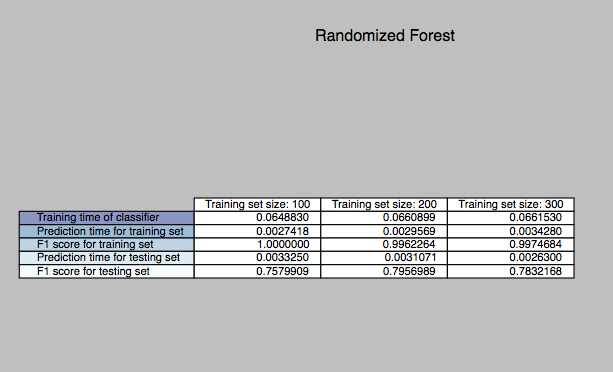

In [312]:
#Refer to Line 312 from student_intervention.py

#Below I am only showing the table from the Model #2 (Randomized Forest classifier)

**Model 3: **

- What are the general applications of this model? What are its strengths and weaknesses?

    The general applications of Bagging Classifier with KNN (Testing Model) are for decision tree methods, although it can be used with any type of method.


  * The strengths of Bagging Classifier with KNN (Testing Model) are that it helps to avoid overfitting and reduces variance.


  * The weaknesses of Bagging Classifier with KNN (Testing Model) are the loss of simplicity [weakness#1](https://uni-obuda.hu/journal/Machova_Barcak_Bednar_6.pdf) and that it can mildly degrade the performance of stable methods such as K-nearest neighbors (Breiman, 1996) [weakness#2](https://en.wikipedia.org/wiki/Bootstrap_aggregating)


- Given what you know about the data so far, why did you choose this model to apply?

    I chose the Bagging Classifier with KNN (Testing Model) to apply because it reduces variance and helps to avoid overfitting. I had not considered that it is mostly used for artificial neural networks, classification and regression trees, and subset selection in linear regression.


- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.


Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Model Bagging Classifier with KNN
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Finished

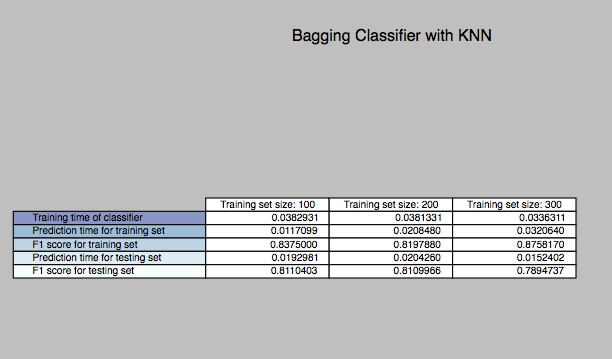

In [312]:
#Refer to Line 312 from student_intervention.py

#Below I am only showing the table from the Model #3 (Bagging classifier)

## 5. Choosing the Best Model

1. Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
2. In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
3. Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
4. What is the model's final F<sub>1</sub> score?

**Answer: **

**1. **
 Based on the available data, limited resources, cost, and performance I chose "Support Vector Classification" or "SVM" as the best model. I followed the logic of the Machine Learning scikit-learn diagram [ML scikit-learn diagram](http://scikit-learn.org/stable/tutorial/machine_learning_map/). Given that I count with less than 100k samples, that I am working with non text data, and that SVM classification is known to be more accurate than Decision Tree classification. [SVM classification](http://web.stanford.edu/dept/itss/docs/oracle/10g/text.101/b10729/classify.htm#i1007173). I also discared the Bagging classifier because it is mostly used for artificial neural networks, classification, regression trees, and subset selection in linear regression [Bootstrap aggregating](https://en.wikipedia.org/wiki/Bootstrap_aggregating). Of course I also discared the linear SVC because compared to the nonlinear SVC, the linear SVC tends to return an underfit model [linear SVC](http://scikit-learn.org/stable/modules/svm.html#classification). In the end following the logic of the diagram I was lead to work with the non linear SVM model.

**Interpreting the Tables**

* *Training time for classifier*: For all the Training set sizes: 100, 200 and 300 the SVM model has the shortest classifier training time.

* *Prediction time for training set*: The Bagging classifier has the shortest prediction time for the training set sizes 100, 200 and 300. After it comes the SVM classifier

* *F1 score for training set*: The Random Forest classifier has the best F1 scores for the training sets: 100, 200 and 300. After it come SVM and the Bagging classifier. SVM has the best score for training sizes 100 and 200. The Bagging classifier has the best F1 scores for the training size 300

* *Prediction time for testing set*: Random Forest classifier has the best prediction time for the testing sets: 100, 200 and 300. Then comes the SVM classifier, and finally the Bagging classifier. 

* *F1 score for testing set*: The Bagging classifier has the best F1 scores for testing the training sizes: 100 and 200. The SVM classifier has the best F1 score for testing he training size: 300.

**Conclusion after interpreting the Tables**

After carefully oberving the Tables, it is clear that the Random Forest classifier gives the best F1 scores for the training of all the set sizes. The F1 scores that it outputs are extremmely close to 1. This can be an indicator that RF is the best model to fit the data. However, when we analyze the F1 scores that it outputs for the testing of all the set sizes, we find out that the Bagging classifier takes the lead for testing the set sizes: 100 and 200. And that the SVM classifier has the best F1 score for the set size: 300. This tells us that Random Forest classifier tends to overfit the data.

Now we are left with the Bagging classifier and the SVM model. The SVM takes the lead in the F1 scores for training the sets: 100 and 200. And the Bagging classifier takes the lead in the F1 score for training the set size 300. Here the last choice is taken by observing the F1 scores for the testing sets. The Bagging classifier has the best F1 scores for testing the training sizes: 100 and 200. But, SVM has the best F1 score for testing the training size: 300. The fact that SVM has the F1 score for testing the set size 300 suggests that the accuracy of the SVM model increases with the set size, while the Bagging classifier does not show a pattern of improvement when increasing the set size. This indicates that perhaps the bagging classifier might not be the best fit for classifiying our data-If we limit ouselves to choosing the less over fitting model with best F1 scores. However, there is one more point that we should consider: the timing which is the amount of computation costs (you pay the company by the memory and CPU time you use on their servers).

Regarding the *Training time for classifier*, for all the Training set sizes: 100, 200 and 300 the SVM model has the shortest classifier training time. Then, the *Prediction time for training set* of the Bagging classifier is the shortest for the training set sizes 100, 200 and 300. After it comes the SVM classifier. And finally, the shortest *Prediction time for testing set* after the Random Forest classifier, belongs to the SVM classifier, and finally the Bagging classifier. We can clearly see that the shortest *Training time for classifier*  and the shortest *Prediction time for testing set* (after the Random Forest classifier) belongs to the SVM classifier, while the Bagging classifier only has the shortest *Prediction time for training set*. In general, SVM seems faster, in addition to having a not over fitting F1 score. This is why I chose SVM as the best classifier.

*Optional: * It is not mandatory to scale features for this project, however please note that feature scaling should be implemented with SVMs, performance might be affected otherwise: [Scaling](http://stats.stackexchange.com/questions/65094/why-scaling-is-important-for-the-linear-svm-classification)

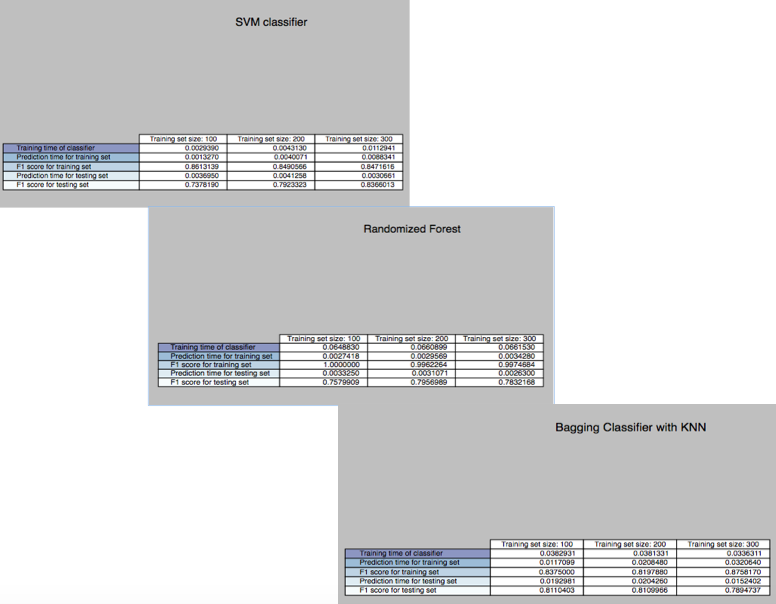

In [312]:
#Refer to Line 312 from student_intervention.py

#Below are all the tables from all the Models

**2. **

**A) Short explanation**:

**SVM** is a method that employs **(1) labeled data** (data with some sort of meaningful "tag," "label," or "class" that is somehow informative or desirable to know. For example, if the student is male or female, what is the size of the student's family, etc. Some labels are: *sex , age , address , famsize , Pstatus , Medu , Fedu , etc.* Check the README.md file for details) and **(2) a function**, an [Iterative training algorithm](http://www.statsoft.com/Textbook/Support-Vector-Machines) (in this case, Classification SVM Type 1, also known as *C-SVM classification*) used to find the largest minimum distance to the training examples (this task is called **margin maximization**). The function used by SVM (in this case, Classification SVM Type 1, also known as **C-SVM classification**), is composed by another function named kernel. The **kernel function** projects the data and makes it separable. There are number of kernels that can be used in Support Vector Machines models. These include linear, polynomial, radial basis function (RBF) and sigmoid. [Kernel functions](http://www.statsoft.com/Textbook/Support-Vector-Machines). To picture what goes on we can imagine that in the last iteration our data is being separated by a line. In this case the students (the points, subset training data) located in the margins of the optimal boundary, are called the **support vectors** (these vectors got updated until the optimal boundary was reached). The **optimal boundary** separates well two categories: passing and failing students. Once done this given **new values** (numerical values), SVM is used to **predict** whether a student will pass or fail.

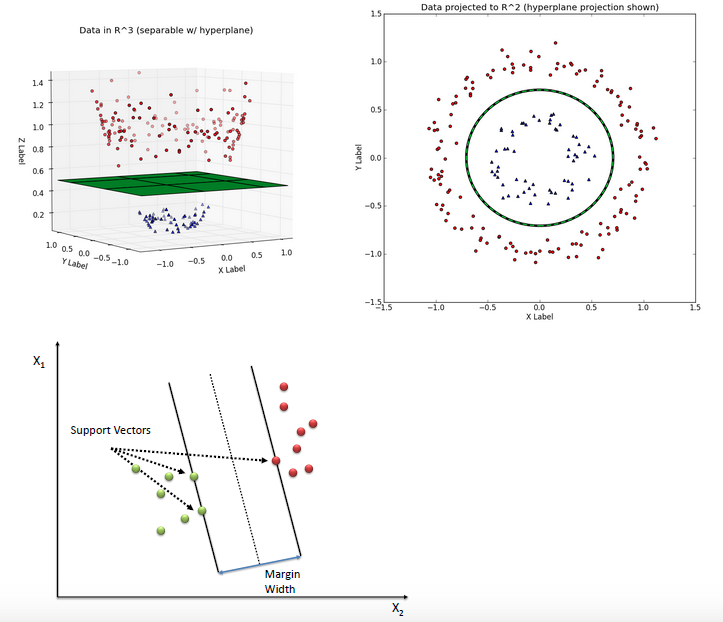

In [6]:
#Some graphics to explain better the SVM model
#Mapping means projecting points onto a plane

**B) Detailed explanation:**
Support Vector Machine (SVM) is a supervised learning method that performs classification tasks by constructing hyperplanes in a multidimensional space that separates cases of different class labels. Given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new data, whether the student will pass or fail.

In [18]:
#refer to README.md file for identifying the meaning of the numbers
new_data = [1, 0, 1, 0, 18, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 
            0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 4, 
            1, 1, 1, 1, 1, 1, 1, 1, 0, 5, 2, 1, 1, 1, 5, 0]
print "lenght of new_data:"
print len(new_data)

print "Predicting: "
print SVM_clf.predict(new_data)
#1 means pass, 0 means fail

lenght of new_data:
48
Predicting: 
 /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/
 site-packages/sklearn/utils/validation.py:386: DeprecationWarning:
 Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError
 in 0.19. Reshape your data either using X.reshape(-1, 1) if your data
 has a single feature or X.reshape(1, -1) if it contains a single sample.
 DeprecationWarning)
[1]

To construct an optimal hyperplane, SVM employs an iterative training algorithm, which is used to minimize an error function. According to the form of the error function, SVM models can be classified into four distinct groups:

    Classification SVM Type 1 (also known as C-SVM classification)

    Classification SVM Type 2 (also known as nu-SVM classification)

    Regression SVM Type 1 (also known as epsilon-SVM regression)

    Regression SVM Type 2 (also known as nu-SVM regression)

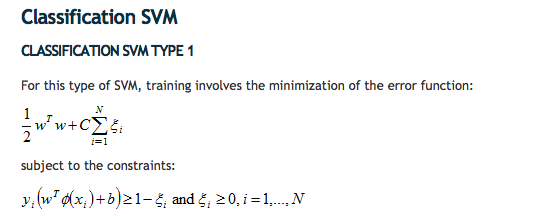

In [1]:
#Classification SVM Type 1 (also known as C-SVM classification)

where C is the capacity constant, w is the vector of coefficients, b is a constant, and represents parameters for handling nonseparable data (inputs). The index i labels the N training cases. Note that represents the class labels and xi represents the independent variables. The kernel is used to transform data from the input (independent) to the feature space. It should be noted that the larger the C, the more the error is penalized. Thus, C should be chosen with care to avoid over fitting.

More specifically, the kernel trick is a mapping done to the training data to improve its resemblance to a linearly separable set of data. This mapping consists of increasing the dimensionality of the data and is done efficiently using a kernel function. When we choose kernel type to be LINEAR it means that no mapping is done. We can observe the kernel that it is being used with the method [get_params](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.get_params), method of the SVC(or SVM) class.

There are number of kernels that can be used in Support Vector Machines models. These include linear, polynomial, radial basis function (RBF) and sigmoid:

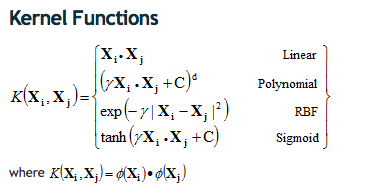

In [2]:
#Kernel functions

that is, the kernel function, represents a dot product of input data points mapped into the higher dimensional feature space by transformation

Gamma is an adjustable parameter of certain kernel functions.

The RBF is by far the most popular choice of kernel types used in Support Vector Machines. This is mainly because of their localized and finite responses across the entire range of the real x-axis. [Kernel functions](http://www.statsoft.com/Textbook/Support-Vector-Machines)

It is important to recall that the SVMs decision function (Classification SVM Type 1, also known as C-SVM classification) depends on some subset of the training data, called support vectors. The training data in the margins of the temporary optimal hyperplane form the support vectors (the margins are hyperplanes, and Classification SVM Type 1 is an iterative training algorithm). Some properties of these support vectors can be found through specific methods: [properties of support vectors](http://scikit-learn.org/stable/modules/svm.html)

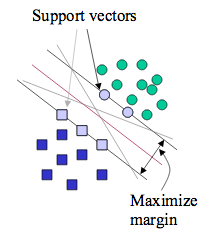

In [3]:
#General idea of Support vectors

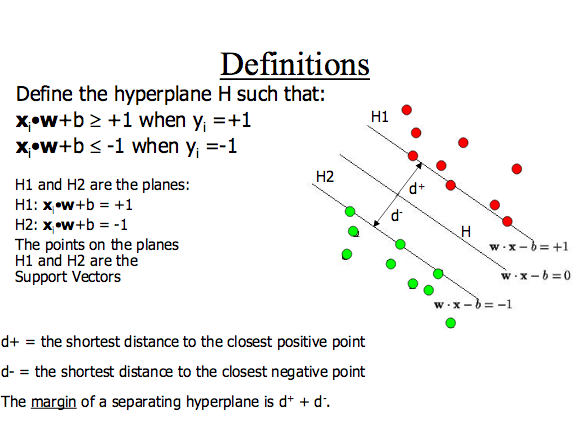

In [4]:
#Details about Support Vectors

In which sense is the hyperplane obtained optimal? Let’s consider the following [simple problem](http://docs.opencv.org/2.4/doc/tutorials/ml/introduction_to_svm/introduction_to_svm.html): 

For a linearly separable set of 2D-points which belong to one of two classes, find a separating straight line.

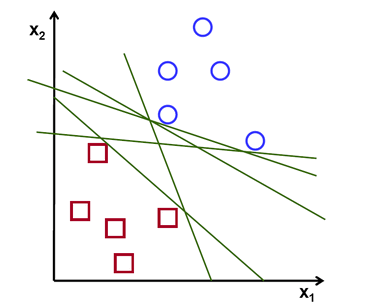

In [5]:
#simple example 

Note: In this example we deal with lines and points in the Cartesian plane instead of hyperplanes and vectors in a high dimensional space. This is a simplification of the problem. It is important to understand that this is done only because our intuition is better built from examples that are easy to imagine. However, the same concepts apply to tasks where the examples to classify lie in a space whose dimension is higher than two.

In the above picture you can see that there exists multiple lines that offer a solution to the problem. Is any of them better than the others? We can intuitively define a criterion to estimate the worth of the lines:

    A line is bad if it passes too close to the points because it will be noise sensitive and 
    it will not generalize correctly. Therefore, our goal should be to find the line passing as 
    far as possible from all points.

Then, the operation of the SVM algorithm is based on finding the hyperplane that gives the largest minimum distance to the training examples. Twice, this distance receives the important name of margin within SVM’s theory. Therefore, the optimal separating hyperplane maximizes the margin of the training data. [Margin Maximization](http://www.statsoft.com/Textbook/Support-Vector-Machines)

SVM supports both regression and classification tasks and can handle multiple continuous and categorical variables.

For categorical variables a dummy variable is created with case values as either 0 or 1. Thus, a categorical dependent variable consisting of three levels, say (A, B, C), is represented by a set of three dummy variables:

**A: {1 0 0}, B: {0 1 0}, C: {0 0 1}**

**3. **

In [225]:
# TODO: Fine-tune your model and report the best F1 score
from sklearn.grid_search import GridSearchCV

def fine_tuning_SVM(parameters, SVM_clf, features_data, target_data, 
                               X_train, y_train, X_test, y_test):
    # Fine-tuning SVM model
    final_svm_clf = GridSearchCV(SVM_clf, parameters, scoring='f1')
    print "%%%%%%%%%%%%%%%%%%%%%%%%%%%%"
    print "Fine-tuning SVM-model: "
    print "%%%%%%%%%%%%%%%%%%%%%%%%%%%%"
    train_predict(final_svm_clf, X_train, y_train, X_test, y_test, grid=True)
    print "Best parameters for the final tuned SVM model: " + str(final_svm_clf.best_params_)

#parameters
parameters = {'kernel':('linear','rbf', 'poly','sigmoid'), 'C':[1, 50], 'degree':[3,6]}

#Fine-tuning SVM model
fine_tuning_SVM(parameters, SVM_clf, features_data, target_data)
print "Finished"

%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Fine-tuning SVM-model: 
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
------------------------------------------
Training set size: 300
Training GridSearchCV...
Done!
Training time (secs): 15.105
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.006
F1 score for training set: 0.802395209581
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.805031446541
Best parameters for the final tuned SVM model: {'kernel': 'sigmoid', 'C': 1, 'degree': 3}
Finished

**4. **
    The F1 score for training set: 0.802395209581
    and The F1 score for test set: 0.805031446541

Note: an **F1 score** reaches its **best value** at **1** and worst at **0**.

*Additional information: [Graph of classifiers](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)